# Music generation using C-RNN-GAN with MIDI network input





### Download & Import packages

---

In [1]:
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!pip install midi2audio
!pip install music21

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin libinput10
  libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5
  libqt5svg5 libqt5widgets5 libwacom-bin libwacom-common libwacom9 libxcb-icccm4 libxcb-image0
  libxcb-keysyms1 libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin libinput10
  libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5
  libqt5svg5 libqt5widgets5 libwacom-bin libwacom-common libwacom9 libxcb-icc

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys, os, glob
import pickle
import matplotlib.pyplot as plt
import numpy as np

from music21 import *
from midi2audio import FluidSynth
from IPython.display import Audio
import random

### MIDI class

---

In [25]:
class MIDI():
    def __init__(self, seq_length):
        self.seq_length = seq_length
        self.file_notes = []
        self.trainseq = []
        self.transfer_dic = dict()
        self.dic_n = 0

    def parser(self, folderName, num_files=2):
        """Parse a subset of MIDI files from a given folder."""
        files = glob.glob(f"{folderName}/*.mid")
        if num_files is not None and num_files < len(files):
            files = random.sample(files, num_files)  # Randomly select 'num_files' files
        for file in files:
            midi = converter.parse(file)
            print(f"Parsing {file}")
            notes = []
            for element in midi.flat.elements:
                if isinstance(element, note.Rest) and element.offset != 0:
                    notes.append('R')
                elif isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(pitch) for pitch in element.pitches))
            self.file_notes.append(notes)

        note_set = sorted(set(note for notes in self.file_notes for note in notes))
        self.dic_n = len(note_set)
        self.transfer_dic = dict((note, number) for number, note in enumerate(note_set))

    def prepare_sequences(self):
      """ Prepare the sequences used by the Neural Network """
      # create input sequences and the corresponding outputs
      for notes in self.file_notes:
          for i in range(len(notes) - self.seq_length):
              self.trainseq.append([self.transfer_dic[note] for note in notes[i:i + self.seq_length]])

      # Normalize sequences between -1 and 1
      self.trainseq = np.array(self.trainseq)
      self.trainseq = (self.trainseq - float(self.dic_n) / 2) / (float(self.dic_n) / 2)

      # Reshape for LSTM [samples, time steps, features]
      self.trainseq = self.trainseq.reshape((self.trainseq.shape[0], self.seq_length, 1))

      return self.trainseq


    def create_midi(self, prediction_output, filename):
        """ convert the output from the prediction to notes and create a midi file
        from the notes """
        offset = 0
        midi_stream = stream.Stream()

        # create note and chord objects based on the values generated by the model
        for pattern in prediction_output:
            # rest
            if pattern == 'R':
                midi_stream.append(note.Rest())
            # chord
            elif ('.' in pattern) or pattern.isdigit():
                notes_in_chord = pattern.split('.')
                notes = []
                for current_note in notes_in_chord:
                    new_note = note.Note(current_note)
                    new_note.storedInstrument = instrument.Piano()
                    notes.append(new_note)
                new_chord = chord.Chord(notes)
                new_chord.offset = offset
                midi_stream.append(new_chord)
            # note
            else:
                new_note = note.Note(pattern)
                new_note.offset = offset
                new_note.storedInstrument = instrument.Piano()
                midi_stream.append(new_note)

            # increase offset each iteration so that notes do not stack
            offset += 0.5

        # midi_stream.show('text')
        midi_stream.write('midi', fp=f'{filename}.mid')

### Model class

---

In [47]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pretty_midi
import glob
from music21 import converter, note, chord, instrument, stream

class LSTMGenerator(nn.Module):
    def __init__(self, seq_length, latent_dim):
        self.seq_length=seq_length
        super(LSTMGenerator, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=512, num_layers=1, batch_first=True)
        self.bidirectional_lstm = nn.LSTM(input_size=512, hidden_size=512, num_layers=1, batch_first=True,
                                          bidirectional=True)
        self.linear_layers = nn.Sequential(
            nn.Linear(1024, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, seq_length),
            nn.Tanh()
        )

    def forward(self, x):
        x, _ = self.lstm(x)
        x, _ = self.bidirectional_lstm(x)
        x = x[:, -1]
        x = self.linear_layers(x)
        return x.view(-1, self.seq_length, 1)


class LSTMDiscriminator(nn.Module):
    def __init__(self, seq_length):
        super(LSTMDiscriminator, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=512, num_layers=1, batch_first=True)
        self.bidirectional_lstm = nn.LSTM(input_size=512, hidden_size=512, num_layers=1, batch_first=True,
                                          bidirectional=True)
        self.linear_layers = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x, _ = self.lstm(x)
        x, _ = self.bidirectional_lstm(x)
        x = x[:, -1]
        x = self.linear_layers(x)
        return x


class CRNNGAN:
    def __init__(self, midi_obj):
        self.midi = midi_obj
        self.seq_length = self.midi.seq_length
        self.latent_dim = 1000

        # Correctly pass the sequence length, not the shape tuple
        self.generator = LSTMGenerator(self.seq_length, self.latent_dim)
        self.discriminator = LSTMDiscriminator(self.seq_length)

        self.optimizer_G = optim.Adam(self.generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
        self.optimizer_D = optim.Adam(self.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

        self.loss = nn.BCELoss()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.generator.to(self.device)
        self.discriminator.to(self.device)

        self.generator.to(self.device)
        self.discriminator.to(self.device)

    def train(self, epochs, data_folder, batch_size=128, sample_interval=50):
        self.midi.parser(data_folder)
        sequences = self.midi.prepare_sequences()
        real_labels = torch.ones((batch_size, 1), device=self.device)
        fake_labels = torch.zeros((batch_size, 1), device=self.device)

        dataset = TensorDataset(torch.tensor(sequences, dtype=torch.float32))
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            for i, (real_seqs,) in enumerate(dataloader):
                try:
                  real_seqs = real_seqs.to(self.device)

                  # Train Discriminator
                  self.discriminator.trainable = True
                  self.optimizer_D.zero_grad()

                  noise = torch.randn(batch_size, self.latent_dim, 1, device=self.device)
                  fake_seqs = self.generator(noise)

                  real_loss = self.loss(self.discriminator(real_seqs), real_labels)
                  fake_loss = self.loss(self.discriminator(fake_seqs.detach()), fake_labels)
                  d_loss = (real_loss + fake_loss) / 2
                  d_loss.backward()
                  self.optimizer_D.step()

                  # Train Generator
                  self.discriminator.trainable = False
                  self.optimizer_G.zero_grad()

                  g_loss = self.loss(self.discriminator(fake_seqs), real_labels)
                  g_loss.backward()
                  self.optimizer_G.step()

                  if i % sample_interval == 0:
                      print(f"Epoch {epoch+1}/{epochs} Batch {i+1}/{len(dataloader)} [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

                except RuntimeError as e:
                    print("RuntimeError: ", e)
                    torch.cuda.empty_cache()  # Clear unused memory

        print("Training completed.")

    def save_models(self):
        if not os.path.exists('Model/'):
            os.makedirs('Model/')
        torch.save(self.generator.state_dict(), 'Model/generator.pth')
        torch.save(self.discriminator.state_dict(), 'Model/discriminator.pth')
        print("Models saved.")

    def generate_music(self):
        noise = torch.randn(1, self.latent_dim, 1, device=self.device)
        generated_seq = self.generator(noise).cpu().detach().numpy()
        self.midi.create_midi(generated_seq, 'generated_music.mid')

    def plot_losses(self):
        plt.figure()
        plt.plot(self.discriminator_losses, color='red')
        plt.plot(self.generator_losses, color='blue')
        plt.title("GAN Losses Over Epochs")
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('/content/GAN_Loss_per_Epoch_final256.png')
        plt.close()

# This refactoring does not change any core functionality but improves readability and maintainability of the code.


In [ ]:
midi = MIDI(seq_length=100)
model = CRNNGAN(midi_interface=midi)
model.train(250, data_folder='/content/drive/MyDrive/midis', batch_size=128, sample_interval=1)

### Save Model

---

In [ ]:
model.save()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


The trained C-RNN-GAN model (generator and discriminator) have been saved in the Model folder.


### Generate Music

---

In [ ]:
model.generate()
!fluidsynth -ni font.sf2 /content/new_song1.mid -F Result/output.wav -r 44100

sound_file = './Result/output.wav'
Audio(sound_file)

1/1 [==============================] - 0s 150ms/step


<ipython-input-5-f032c2c567f6>:150: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_notes = [notes[int(x)] for x in pred_nums]


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'Result/output.wav'..


### Model loss function

---

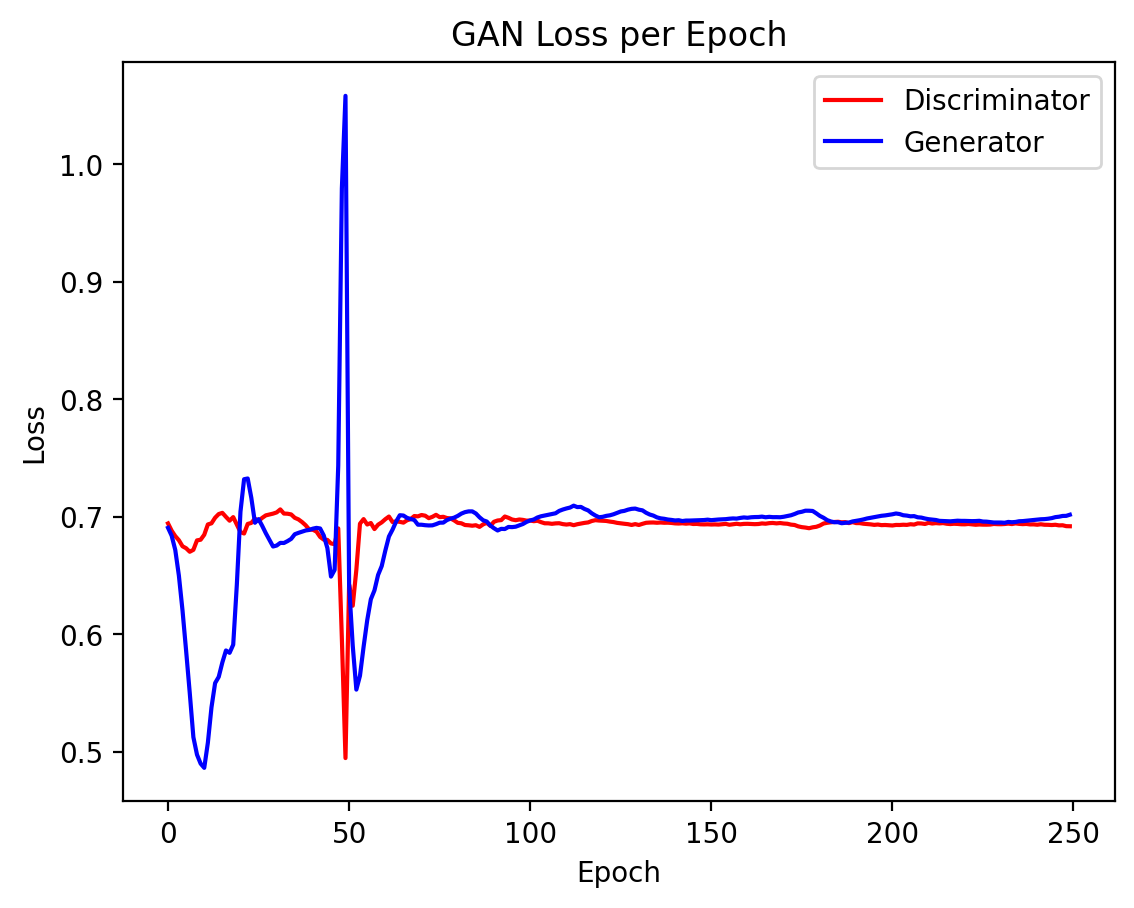

In [ ]:
model.plot_loss()

In [ ]:
import librosa
!pip install pretty_midi
import pretty_midi

<ipython-input-13-28ccd094045d>:13: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pianoroll[start_pitch:end_pitch], hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note', fmin=pretty_midi.note_number_to_hz(start_pitch))


<Figure size 1200x600 with 0 Axes>

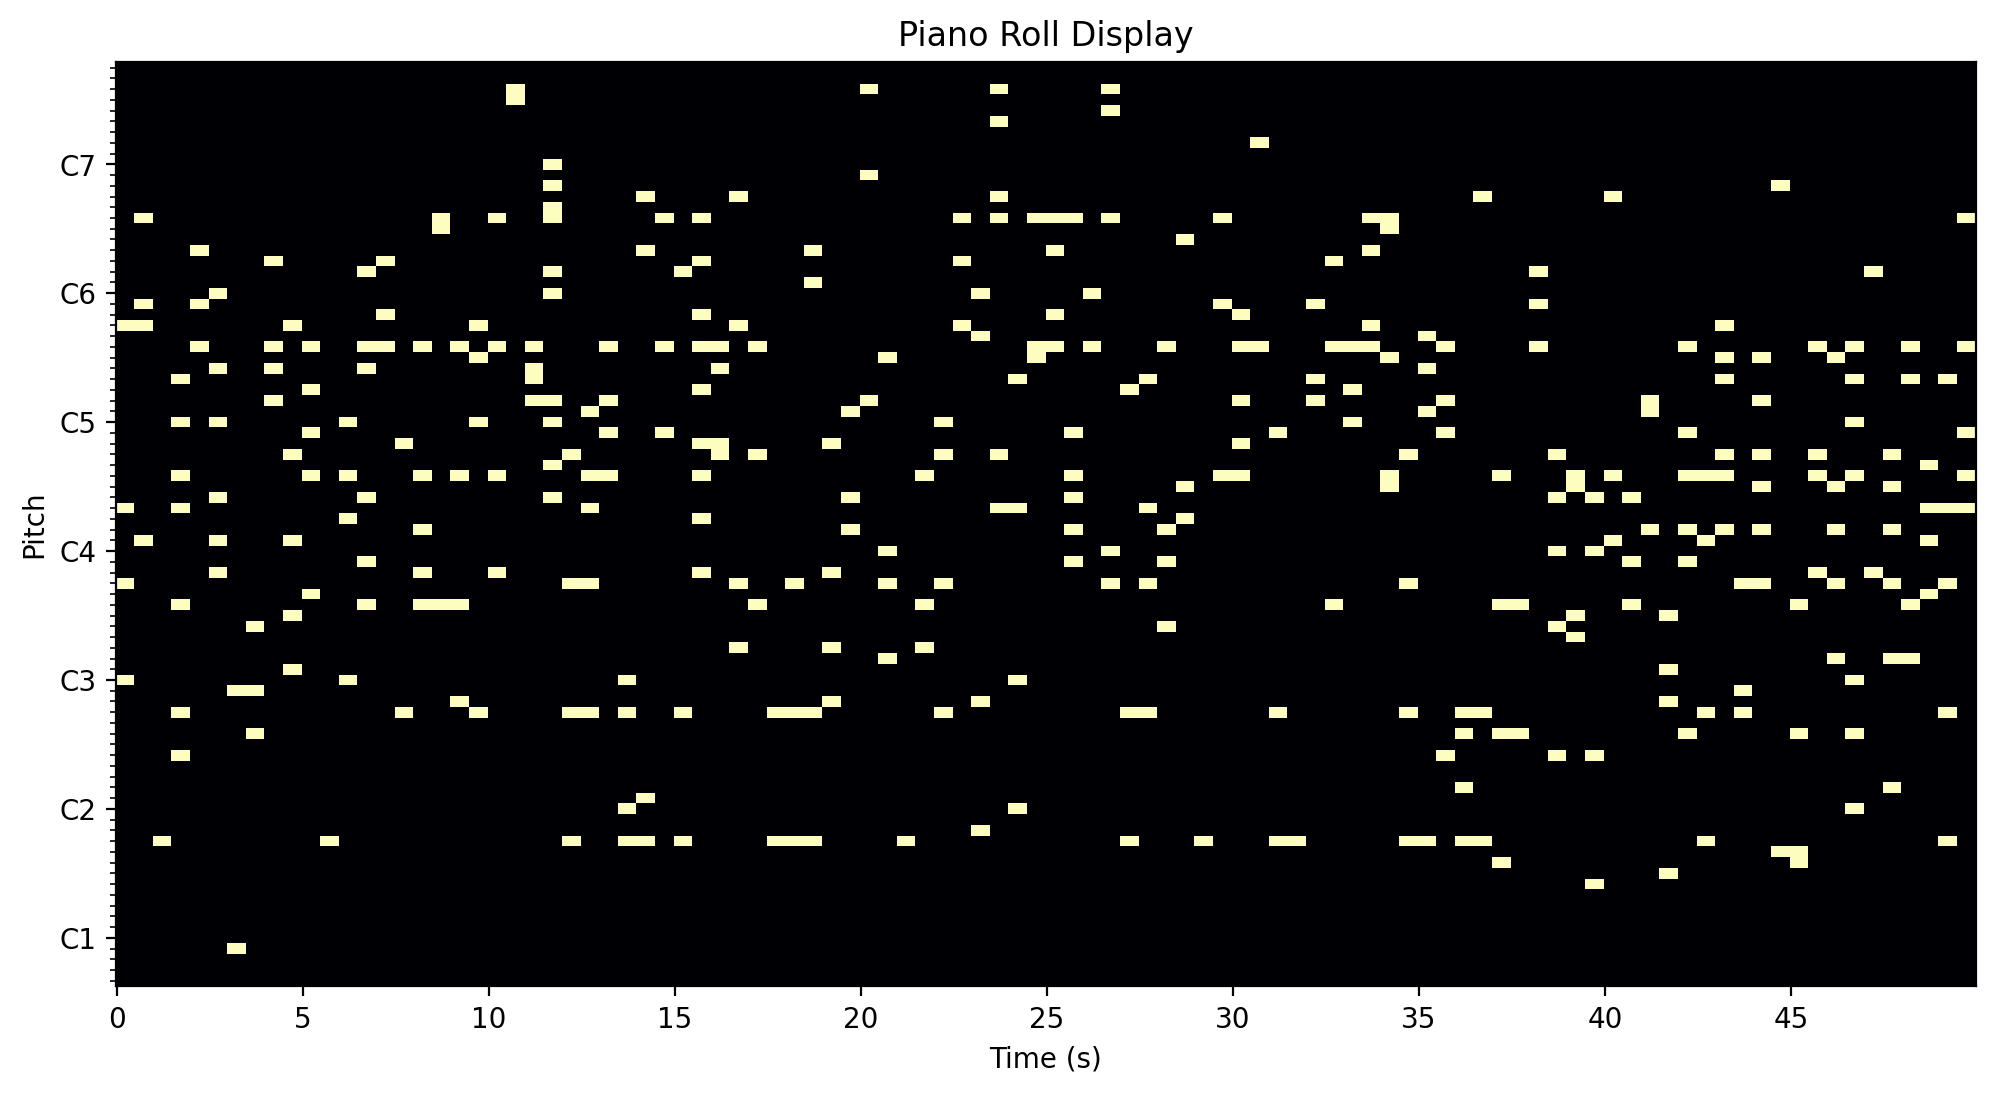

In [ ]:
def plot_piano_roll(pm, length, fs=16):
    plt.figure(figsize=(12, 6))
    # get pianoroll
    pianoroll = pm.get_piano_roll(fs)
    pianoroll[pianoroll > 0] = 1  
    pianoroll = pianoroll[:, :fs * length]  
    nonzero_row_indices = np.nonzero(np.count_nonzero(pianoroll, axis=1))
    start_pitch = max(np.min(nonzero_row_indices) - 3, 0)
    end_pitch = min(np.max(nonzero_row_indices) + 3, 127)

    # plot pianoroll
    plt.figure(figsize=(12, 6)) 
    librosa.display.specshow(pianoroll[start_pitch:end_pitch], hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note', fmin=pretty_midi.note_number_to_hz(start_pitch))

    plt.title('Piano Roll Display')
    plt.xlabel('Time (s)')
    plt.ylabel('Pitch')



pm = pretty_midi.PrettyMIDI('/content/Result/gan_final.mid')
plot_piano_roll(pm, 50)

### Evaluation

In [ ]:
midi = converter.parse('/content/gan_final.mid')

notes = []
chords = []

# Record notes and chords
for element in midi.recurse():
    if isinstance(element, note.Note):
        notes.append((element.pitch, element.duration.quarterLength))
    elif isinstance(element, chord.Chord):
        chords.append(('.'.join(str(n) for n in element.pitches), element.duration.quarterLength))

print("Found {} notes and {} chords in the MIDI file.".format(len(notes), len(chords)))

Found 5 notes and 95 chords in the MIDI file.


In [ ]:
def evaluate_diversity(midi_data):
    pitch_set = set()
    rhythm_set = set()
    previous_end = 0

    # Collect information from all instruments
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            pitch_set.add(note.pitch)
            # Calculate inter-onset intervals to analyze rhythm diversity
            if note.start > previous_end:
                rhythm_set.add(round(note.start - previous_end, 2))
            previous_end = note.end

    # Calculate diversity metrics
    pitch_diversity = len(pitch_set)
    rhythm_diversity = len(rhythm_set)
    total = pitch_diversity + rhythm_diversity

    return total

In [ ]:
from music21 import converter, analysis

def interval_in_semitones(note1, note2):
    return abs(note1.pitch - note2.pitch)

def music_theory_consistency(midi_data):
    consonant_intervals = {3, 4, 5, 7, 8, 12}  # Minor third, Major third, Perfect fourth, Perfect fifth, Octave, Perfect octave
    consistent_intervals_count = 0
    total_intervals = 0

    for instrument in midi_data.instruments:
        notes = instrument.notes
        for i in range(len(notes) - 1):
            interval = interval_in_semitones(notes[i], notes[i+1])
            if interval in consonant_intervals:
                consistent_intervals_count += 1
            total_intervals += 1

    if total_intervals > 0:
        consistency_score = consistent_intervals_count / total_intervals
    else:
        consistency_score = 0

    return consistency_score


In [ ]:
def measure_rhythmic_complexity(midi_data):
    unique_durations = set()
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            unique_durations.add(note.duration)
    complexity_score = len(unique_durations)
    return complexity_score


In [ ]:
def pitch_rhythm_stability(midi_data):
    pitch_count = {}
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            if note.pitch in pitch_count:
                pitch_count[note.pitch] += 1
            else:
                pitch_count[note.pitch] = 1
    max_repetition = max(pitch_count.values()) if pitch_count else 0
    return max_repetition

In [ ]:
midi_file_path = '/content/sample2.mid'
midi_data = pretty_midi.PrettyMIDI(midi_file_path)

# Now call the functions with the MIDI data
rhythmic_complexity = measure_rhythmic_complexity(midi_data)
pitch_stability = pitch_rhythm_stability(midi_data)
music_theory_consistenc = music_theory_consistency(midi_data)
a = evaluate_diversity(midi_data)

print("Rhythmic Complexity:", rhythmic_complexity)
print("Pitch Rhythm Stability:", pitch_stability)
print("Music theory consistency:", music_theory_consistenc)
print("Evaluated diversity:", a)


Rhythmic Complexity: 92
Pitch Rhythm Stability: 27
Music theory consistency: 0.40784313725490196
Evaluated diversity: 29
